In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import math
import torch.nn.functional as F


# from util import onehot

Downloading the dataset

In [2]:
MNIST_train = datasets.MNIST(root='./data', train = True , download=True, transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
MNIST_test = datasets.MNIST(root='./data', train = False ,download=True, transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

100%|██████████| 9912422/9912422 [00:00<00:00, 113053971.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9140936.75it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28709748.83it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16422869.63it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Splitting the train dataset into train and validation dataset

In [3]:
train_data, val_data = random_split(MNIST_train, [50000,10000])

In [4]:
train = torch.utils.data.DataLoader(train_data, batch_size=100,shuffle=True)

val = torch.utils.data.DataLoader(val_data, batch_size=100,shuffle=True)

test = torch.utils.data.DataLoader(MNIST_test, batch_size=100,shuffle=True)


In [5]:
device = torch.device("cuda")
print(device)

cuda


In [6]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


Building an RNN model for image classification

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt


MNIST_train = datasets.MNIST(root='./data', train = True , download=True, transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
MNIST_test = datasets.MNIST(root='./data', train = False ,download=True, transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
train_data, val_data = random_split(MNIST_train, [50000,10000])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=100,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=100,shuffle=True)
test_loader = torch.utils.data.DataLoader(MNIST_test, batch_size=100,shuffle=True)

# Step 2: Define the architecture of the RNN model
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        x = x.view(x.size(0), x.size(2), -1)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out



Training the dataset
We are taking 10 epochs
Calculting the training loss and validation accuracy and printing the average validation accuracy after training. We also plot the required graphs.

Epoch 1/10: Train Loss 0.8857, Val Loss 0.5183, Val Accuracy 84.22%
Epoch 2/10: Train Loss 0.4091, Val Loss 0.3251, Val Accuracy 90.85%
Epoch 3/10: Train Loss 0.2853, Val Loss 0.2615, Val Accuracy 92.58%
Epoch 4/10: Train Loss 0.2192, Val Loss 0.1906, Val Accuracy 94.75%
Epoch 5/10: Train Loss 0.1815, Val Loss 0.2087, Val Accuracy 94.28%
Epoch 6/10: Train Loss 0.1612, Val Loss 0.1629, Val Accuracy 95.67%
Epoch 7/10: Train Loss 0.1453, Val Loss 0.1766, Val Accuracy 95.03%
Epoch 8/10: Train Loss 0.1409, Val Loss 0.1457, Val Accuracy 96.26%
Epoch 9/10: Train Loss 0.1289, Val Loss 0.2153, Val Accuracy 93.50%
Epoch 10/10: Train Loss 0.1262, Val Loss 0.1475, Val Accuracy 95.97%


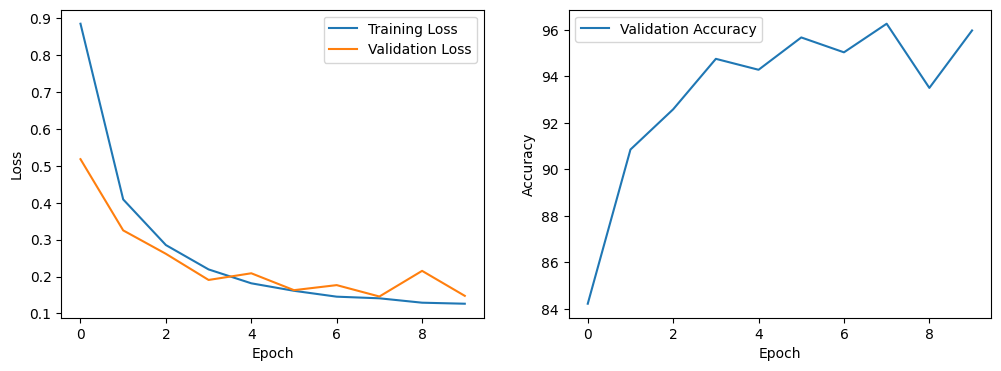

The average val_accuracy_history= 93.31099999999999


In [9]:

val_accuracy_history = []

# Train and evaluate the model
input_size = 28  # Input dimension (each time step)
hidden_size = 128  # Hidden state size
output_size = 10  # Number of classes

model = RNNClassifier(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, train_loader, optimizer, criterion, num_epochs):
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss_history.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                # images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss_history.append(val_loss / len(val_loader))
        val_accuracy = 100 * correct / total
        val_accuracy_history.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss {train_loss_history[-1]:.4f}, Val Loss {val_loss_history[-1]:.4f}, Val Accuracy {val_accuracy:.2f}%")

    # Plot training and validation metrics
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Calculating the average prediction accuracy
    avg = 0
    for i in val_accuracy_history:
      avg += i
    avg = avg/len(val_accuracy_history)
    print("The average val_accuracy_history= " + str(avg))

    # return train_loss_history, val_loss_history, val_accuracy_history

num_epochs = 10
# train_losses, val_losses, val_accuracies =
train(model, train_loader, optimizer, criterion, num_epochs)





The below code performs the testing on the test data and prints the accuracy

In [10]:
# Test the model
def test_model(model):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            # images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
test_model(model)

Test Accuracy: 96.21%


Here we are defining LSTM classifier instead of classic RNN as it is better than RNN when it comes to remembering useful information from the previous layers.

In [11]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), x.size(2), -1)
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get output from the last time step
        return out

Epoch 1/10: Train Loss 0.4906, Val Loss 0.1922, Val Accuracy 94.26%
Epoch 2/10: Train Loss 0.1229, Val Loss 0.1078, Val Accuracy 96.79%
Epoch 3/10: Train Loss 0.0838, Val Loss 0.0871, Val Accuracy 97.46%
Epoch 4/10: Train Loss 0.0626, Val Loss 0.0770, Val Accuracy 97.84%
Epoch 5/10: Train Loss 0.0527, Val Loss 0.0715, Val Accuracy 97.77%
Epoch 6/10: Train Loss 0.0433, Val Loss 0.0720, Val Accuracy 97.91%
Epoch 7/10: Train Loss 0.0354, Val Loss 0.0573, Val Accuracy 98.38%
Epoch 8/10: Train Loss 0.0329, Val Loss 0.0507, Val Accuracy 98.57%
Epoch 9/10: Train Loss 0.0292, Val Loss 0.0506, Val Accuracy 98.53%
Epoch 10/10: Train Loss 0.0243, Val Loss 0.0572, Val Accuracy 98.29%


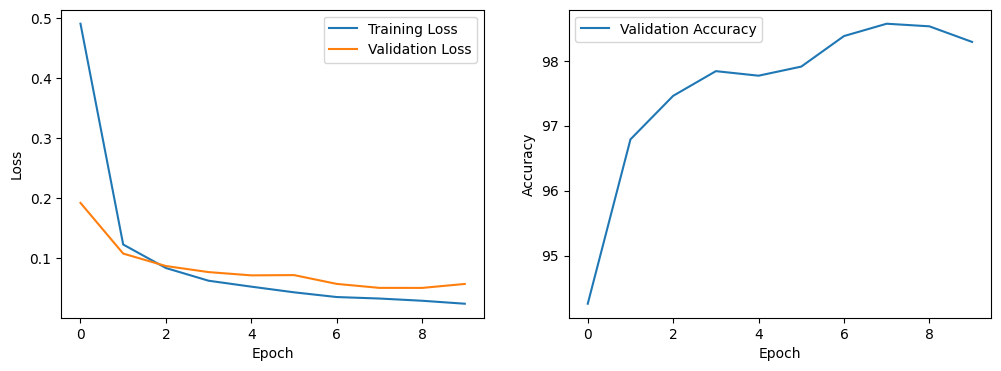

The average val_accuracy_history= 97.58


In [12]:
# Initialize the LSTM RNN model
input_size = 28
hidden_size = 128
num_classes = 10
lstm_model = LSTMClassifier(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

num_epochs = 10
train(lstm_model, train_loader, optimizer, criterion, num_epochs)


In [13]:
test_model(lstm_model)

Test Accuracy: 98.42%


Bidirectional LSTM Model

In [14]:
# Define the Bidirectional LSTM model
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), x.size(2), -1)
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device) # 2 for bidirectional
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


Epoch 1/10: Train Loss 0.5325, Val Loss 0.1507, Val Accuracy 95.39%
Epoch 2/10: Train Loss 0.1144, Val Loss 0.0966, Val Accuracy 97.24%
Epoch 3/10: Train Loss 0.0791, Val Loss 0.0757, Val Accuracy 97.71%
Epoch 4/10: Train Loss 0.0596, Val Loss 0.0653, Val Accuracy 98.05%
Epoch 5/10: Train Loss 0.0460, Val Loss 0.0716, Val Accuracy 97.96%
Epoch 6/10: Train Loss 0.0411, Val Loss 0.0555, Val Accuracy 98.36%
Epoch 7/10: Train Loss 0.0363, Val Loss 0.0617, Val Accuracy 98.17%
Epoch 8/10: Train Loss 0.0293, Val Loss 0.0550, Val Accuracy 98.34%
Epoch 9/10: Train Loss 0.0244, Val Loss 0.0589, Val Accuracy 98.37%
Epoch 10/10: Train Loss 0.0238, Val Loss 0.0554, Val Accuracy 98.48%


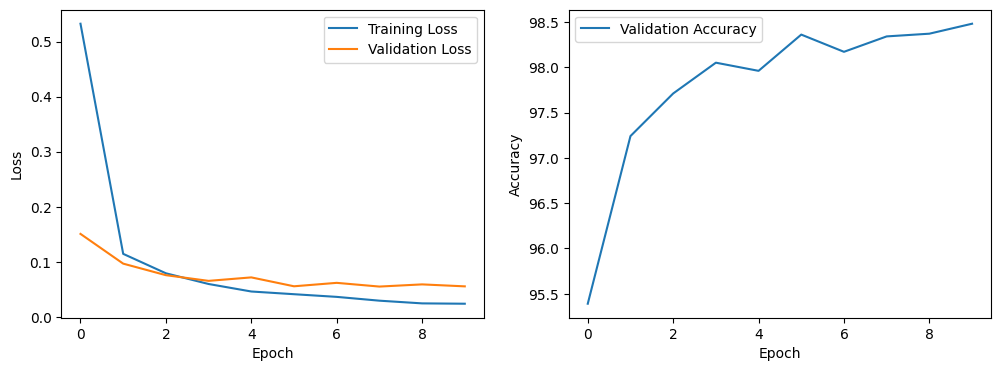

The average val_accuracy_history= 97.80699999999999


In [16]:
input_size = 28
hidden_size = 128
num_classes = 10
bilstm_model = BiLSTMClassifier(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.001)

num_epochs = 10
train(bilstm_model, train_loader, optimizer, criterion, num_epochs)

In [17]:
test_model(bilstm_model)

Test Accuracy: 98.48%


Randomly choosing 5 images and checking if the best model i.e. BiLSTM is able to predict accurately, we observe that all the values are predicted acccurately

Images:


<ipython-input-18-5c721b310a72>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax=plt.subplot(1,5,k)


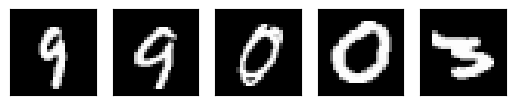

Prediction: [9. 9. 0. 0. 3.]
Real label: [9. 9. 0. 0. 3.]


In [18]:
k=1
print('Images:')
a=(5*np.abs(np.random.rand(5))).astype(int)
predict=np.zeros(5)
actual=np.zeros(5)
fig,ax = plt.subplots()
for i in range(5):
    for images,labels in test_loader:
        images = images.reshape(-1, 28, 28)
        ax=plt.subplot(1,5,k)
        ax.set_xticks([])
        ax.set_yticks([])
        im=ax.imshow(images[a[i]].cpu().reshape(28,28),cmap='gray')
        _,predicted=torch.max(bilstm_model(images)[a[i]],0)
        predict[i]=predicted.item()
        actual[i]=labels[a[i]]
        break
    k+=1
plt.show()
print('Prediction:',predict)
print('Real label:',actual)

Handwritten digits: The data is given which is handwritten and we test the model if it can predict the same. In the process we make sure to flip the colours as background needs to be black to match the mnist image style.


In [19]:
import cv2
import torch
import numpy as np

images = ['digit_0.jpeg','digit_1.jpeg','digit_2.jpeg','digit_3.jpeg','digit_4.jpeg','digit_5.jpeg','digit_6.jpeg','digit_7.jpeg','digit_8.jpeg','digit_9.jpeg']
matrix_image = []

# Load the image using OpenCV and convert it to PyTorch tensors
for data in images:
    image = cv2.imread(data)

    if image is not None:
        # Resize the image to the desired shape (e.g., 28x28)
        desired_shape = (28, 28)
        resized_image = cv2.resize(image, desired_shape)

        # Convert the resized image to a NumPy array as float32
        image_np = np.asarray(resized_image, dtype=np.float32)

        # Convert the NumPy array to a PyTorch tensor
        image_tensor = torch.from_numpy(image_np).permute(2, 0, 1)  # Change the dimension order as needed

        # Convert to grayscale and normalize the values to the [0, 1] range
        gray_scale_image_tensor = torch.mean(image_tensor, dim=0, keepdim=True) / 255.0
        # gray_scale_image_tensor =
        matrix_image.append(1-gray_scale_image_tensor)

stacked_images = torch.stack(matrix_image, dim=0)


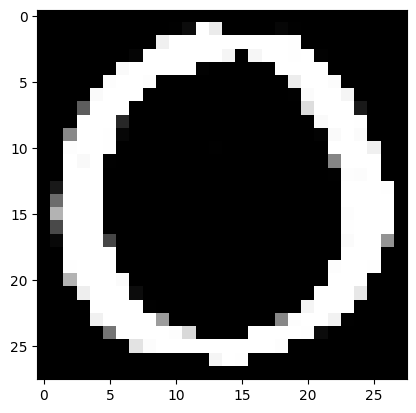

In [20]:
import matplotlib.pyplot as plt
plt.imshow(torch.reshape(stacked_images[0],(28,28)),cmap='gray')
plt.show()


In [32]:
import os
name = os.listdir()

Images:


<ipython-input-37-b8c801c616ef>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax=plt.subplot(1,10,k+1)


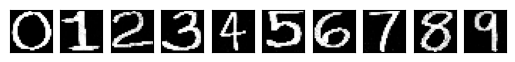

Prediction RNN: [5. 7. 5. 5. 6. 0. 5. 6. 7. 5.]
Prediction LSTM: [0. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
Real label: [0.         0.00392157 0.00392157 0.00392157 0.         0.00392157
 0.         0.         0.00392157 0.        ]
Images:


<ipython-input-38-b8c801c616ef>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax=plt.subplot(1,10,k+1)


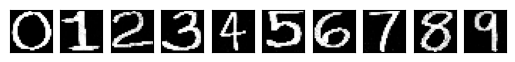

Prediction RNN: [5. 7. 5. 5. 6. 0. 5. 6. 7. 5.]
Prediction LSTM: [0. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
Real label: [0.         0.00392157 0.00392157 0.00392157 0.         0.00392157
 0.         0.         0.00392157 0.        ]


In [38]:
from PIL import Image, ImageOps

k=0
print('Images:')
predict_rnn=np.zeros(10)
# predict_birnn=np.zeros(10)
predict_lstm=np.zeros(10)
predict_bilstm=np.zeros(10)
actual=np.zeros(10)
fig,ax = plt.subplots()
for j in stacked_images:
    # im = Image.open(j).resize((28,28))
    # im = ImageOps.grayscale(im)
    # image = binary_image(im)
    # images = image.repeat(100,1,1)
    # images = images.to("cuda")
    ax=plt.subplot(1,10,k+1)
    ax.set_xticks([])
    ax.set_yticks([])
    im=ax.imshow(j.cpu().reshape(28,28),cmap='gray')
    _,predicted=torch.max(model(j)[0],0)
    predict_rnn[k]=predicted.item()
    _,predicted=torch.max(lstm_model(j)[0],0)
    predict_lstm[k]=predicted.item()
    # _,predicted=torch.max(bilstm_model(images)[0],0)
    # predict_bilstm[k]=predicted.item()
    actual[k] = j[0,0,0]
# actual[k]=int(j[0][0])
    k+=1
plt.show()
print('Prediction RNN:',predict_rnn)
# print('Prediction BIRNN:',predict_birnn)
print('Prediction LSTM:',predict_lstm)
# print('Prediction BILSTM:',predict_bilstm)
print('Real label:',actual)

The prediction is not accurate which might be due to the way the data is written

# Adding two binary strings


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

**Data preparation**

In [40]:
def bin_gen(L):
    N1 = np.random.randint(0, 2 ** (L - 1))
    N2 = np.random.randint(0, 2 ** (L - 1))
    S = N1 + N2

    B1 = np.flip(np.array(list(np.binary_repr(N1, width=L)), dtype=int))
    B2 = np.flip(np.array(list(np.binary_repr(N2, width=L)), dtype=int))
    B3 = np.flip(np.array(list(np.binary_repr(S, width=L)), dtype=int))
    x = np.vstack((B1, B2)).T
    y = torch.tensor(B3.copy())
    z = torch.tensor(x.copy())
    return z,y

def generate_data(size,l=3):
    data=[]
    target=[]
    for i in range(size):
        a,b=bin_gen(l)
        data.append(a)
        target.append(b)
    return data,target

Defining the model to add the two binary strings

In [42]:
class LSTM_bit_add(nn.Module):

    def __init__(self,hidsize):
        super(LSTM_bit_add, self).__init__()
        self.hidsize=hidsize
        self.lstm = nn.LSTM(2,hidsize)
        self.layer2 = nn.Sequential(
            nn.Linear(hidsize,1),
            nn.Sigmoid())

    def forward(self, X):
        X=X.permute(1,0,2)
        hiddenstate=torch.zeros(1,X.size(1),self.hidsize)
        cellstate=torch.zeros(1,X.size(1),self.hidsize)
        out,(hs,cs) = self.lstm(X,(hiddenstate,cellstate))
        out = self.layer2(out)
        return out.reshape(X.size(0))

Training is happenening depending on the loss function i.e MSE or Cross Entropy

In [43]:
def train_bin_add(train_input,test_input,loss_f,hidstate = 3,epochs = 10):
    metrics = {"train_loss": [],"test_loss": [],"correct_test":[]}
    model=LSTM_bit_add(hidstate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        for i in range(int(len(train_input[0]))):
            # a=torch.zeros((1,train_input[0][i].shape[0],train_input[0][i].shape[1]))
            a=train_input[0][i]
            a = a.view(1,a.size(0),a.size(1))
            output=model(a.float())
            print()
            label=(train_input[1][i])
            loss = loss_f(output,label.float())
            metrics["train_loss"].append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        iteration=0
        tempvalloss=0
        correctval=0

        for i in range(len(test_input[0])):
            correct=0
            # a=torch.zeros((1,test_input[0][i].shape[0],test_input[0][i].shape[1]))
            a=test_input[0][i]
            a = a.view(1,a.size(0),a.size(1))
            output=model(a.float())
            label=(test_input[1][i])
            loss = loss_f(output,label.float())
            iteration+=1
            tempvalloss+=loss.item()

            predicted=torch.zeros(output.shape)
            predicted= torch.round(predicted)
            correct += (predicted == label.float()).sum().item()/len(label)

        metrics["correct_test"].append(100*correct/iteration)
        metrics["test_loss"].append(tempvalloss/iteration)
    print(metrics)
    return model,metrics

Test function for the same

In [44]:
def test_bin_add(model,test_data):
    model.eval()
    correct = 0
    # correctarr2 = np.zeros(20)
    with torch.no_grad():
        for i in range(len(test_data[0])):
            # a=torch.zeros((1,test_data[0][i].shape[0],test_data[0][i].shape[1]))
            a=test_data[0][i]
            a = a.view(1,a.size(0),a.size(1))
            output=model(a.float())
            label=(test_data[1][i]).float()
            predicted=torch.zeros(output.shape)
            predicted[output>=0.5]=1
            predicted[output<0.5]=0
            # print(len(label))
            correct += (predicted == label).sum().item()/len(label)
            # correctarr1[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))
        print('Bit accuracy :',((correct)/len(test_data[0]))*100, "%")

In [45]:
learning_rate = 0.01
epochs = 10
# loss_mse = nn.MSELoss()
train_size = 1000
test_size = 100
hidstate = 3

**MSE Loss**

In [63]:
model_bin_3,metric_bin_3 = train_bin_add(train_input = generate_data(size = train_size,l=3) , test_input = generate_data(size = test_size,l=3) ,loss_f=nn.MSELoss(),hidstate = 3)
model_bin_5,metric_bin_5 = train_bin_add(train_input = generate_data(size = train_size,l=5) , test_input = generate_data(size = test_size,l=5),loss_f=nn.MSELoss() ,hidstate = 3)
model_bin_10,metric_bin_10 = train_bin_add(train_input = generate_data(size = train_size,l=10) , test_input = generate_data(size = test_size,l=10),loss_f=nn.MSELoss() ,hidstate = 3)


#Please scroll down to the next cell



Streaming output truncated to the last 5000 lines.























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































We train the data for lengths 3,5,10 for hidden layers = 3
The bit accuracy is printed after testing is done, the results are good

In [64]:
test_bin_add(model_bin_3,test_data = generate_data(size = 20,l=3))

Bit accuracy : 100.0 %


In [65]:
test_bin_add(model_bin_3,test_data = generate_data(size = 20,l=5))

Bit accuracy : 86.00000000000001 %


In [66]:
test_bin_add(model_bin_3,test_data = generate_data(size = 20,l=10))

Bit accuracy : 78.5 %


**Cross entropy loss**

In [67]:
model_bin_3c,metric_bin_3c = train_bin_add(train_input = generate_data(size = train_size,l=3) , test_input = generate_data(size = test_size,l=3) ,loss_f=nn.BCELoss(),hidstate = hidstate)
model_bin_5c,metric_bin_5c = train_bin_add(train_input = generate_data(size = train_size,l=5) , test_input = generate_data(size = test_size,l=5),loss_f=nn.BCELoss() ,hidstate = hidstate)
model_bin_10c,metric_bin_10c = train_bin_add(train_input = generate_data(size = train_size,l=10) , test_input = generate_data(size = test_size,l=10),loss_f=nn.BCELoss() ,hidstate = hidstate)



Streaming output truncated to the last 5000 lines.























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































We train the data for lengths 3,5,10 for hidden layers = 3
The bit accuracy is printed after testing is done, the results are good
The only difference from above is the loss function

In [68]:
test_bin_add(model_bin_3,test_data = generate_data(size = 20,l=3))

Bit accuracy : 100.0 %


In [69]:
test_bin_add(model_bin_3,test_data = generate_data(size = 20,l=10))

Bit accuracy : 81.5 %


In [70]:
test_bin_add(model_bin_3,test_data = generate_data(size = 20,l=5))

Bit accuracy : 93.0 %


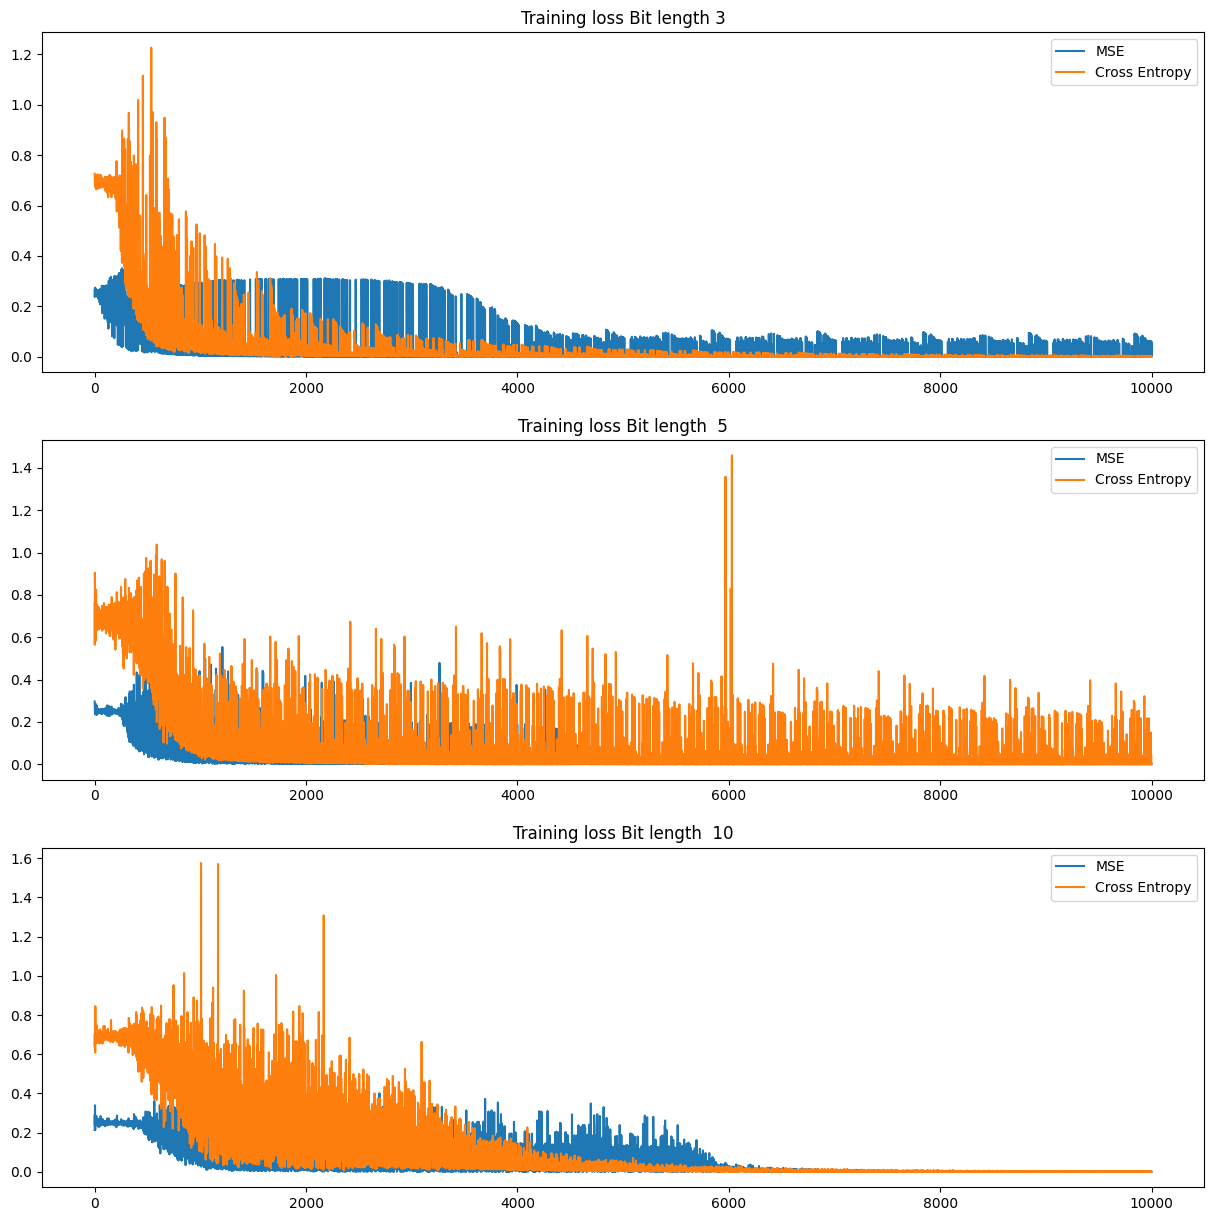

In [71]:
fig , (model_3,model_5,model_10) =  plt.subplots(3,1,figsize=(15, 15))

model_3.plot(metric_bin_3["train_loss"],label = "MSE")
model_3.plot(metric_bin_3c["train_loss"],label = "Cross Entropy")
model_3.title.set_text("Training loss Bit length 3")
model_3.legend()

model_5.plot(metric_bin_5["train_loss"],label = "MSE")
model_5.plot(metric_bin_5c["train_loss"],label = "Cross Entropy")
model_5.legend()
model_5.title.set_text("Training loss Bit length  5")

model_10.plot(metric_bin_10["train_loss"],label = "MSE")
model_10.plot(metric_bin_10c["train_loss"],label = "Cross Entropy")
model_10.legend()
model_10.title.set_text("Training loss Bit length  10")

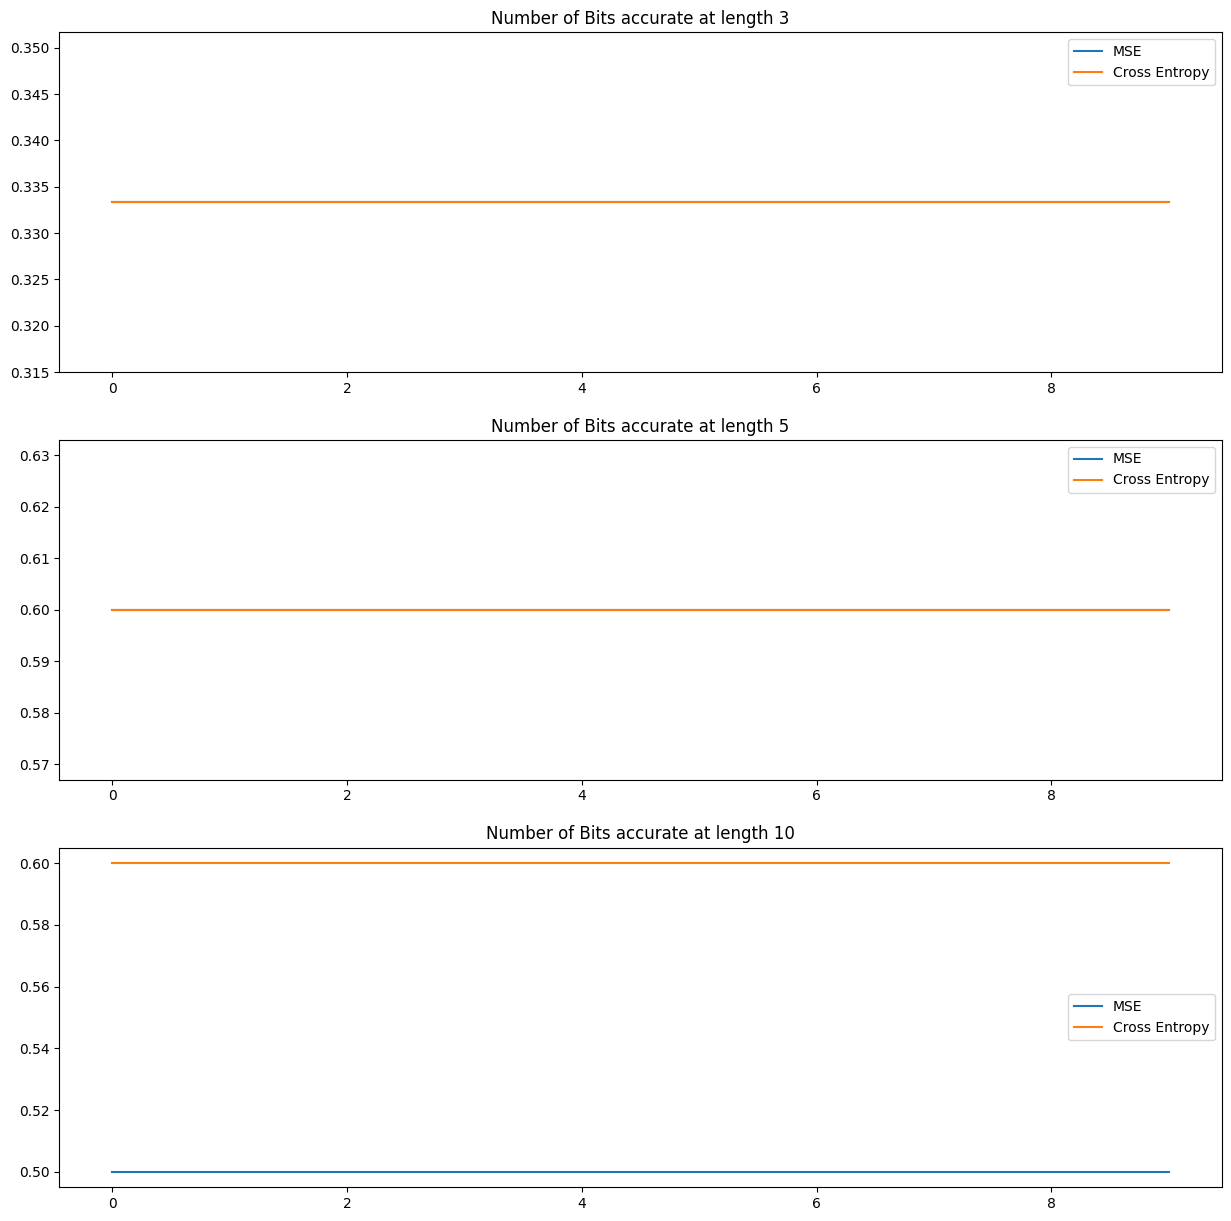

In [72]:
fig , (model_3,model_5,model_10) =  plt.subplots(3,1,figsize=(15, 15))
model_3.plot(metric_bin_3["correct_test"],label = "MSE")
model_3.plot(metric_bin_3c["correct_test"],label = "Cross Entropy")
model_3.title.set_text("Number of Bits accurate at length 3")
model_3.legend()


model_5.plot(metric_bin_5["correct_test"],label = "MSE")
model_5.plot(metric_bin_5c["correct_test"],label = "Cross Entropy")
model_5.title.set_text("Number of Bits accurate at length 5")
model_5.legend()

model_10.plot(metric_bin_10["correct_test"],label = "MSE")
model_10.plot(metric_bin_10c["correct_test"],label = "Cross Entropy")
model_10.title.set_text("Number of Bits accurate at length 10")
model_10.legend()

**MSE Hidden Layer = 5**

In [75]:
model_bin_3_hid_5,metric_bin_3_hid_5 = train_bin_add(train_input = generate_data(size = train_size,l=3) , test_input = generate_data(size = test_size,l=3) ,loss_f=nn.MSELoss() ,hidstate = 5)
model_bin_5_hid_5,metric_bin_5_hid_5 = train_bin_add(train_input = generate_data(size = train_size,l=5) , test_input = generate_data(size = test_size,l=5) ,loss_f=nn.MSELoss() ,hidstate = 5)
model_bin_10_hid_5,metric_bin_10_hid_5 = train_bin_add(train_input = generate_data(size = train_size,l=10) , test_input = generate_data(size = test_size,l=10) ,loss_f =nn.MSELoss() ,hidstate = 5)


Streaming output truncated to the last 5000 lines.























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [76]:
test_bin_add(model_bin_3_hid_5,test_data = generate_data(size = 20,l=3))

Bit accuracy : 100.0 %


In [77]:
test_bin_add(model_bin_5_hid_5,test_data = generate_data(size = 20,l=5))

Bit accuracy : 100.0 %


In [78]:
test_bin_add(model_bin_10_hid_5,test_data = generate_data(size = 20,l=10))

Bit accuracy : 100.0 %


**CROSS ENTROPY Hidden layer = 5, lengths = 3,5,10**

In [79]:
model_bin_3_ce_hid_5,metric_bin_3_ce_hid_5 = train_bin_add(train_input = generate_data(size = train_size,l=3) , test_input = generate_data(size = test_size,l=3) ,loss_f=nn.BCELoss(),hidstate = 5)
model_bin_5_ce_hid_5,metric_bin_5_ce_hid_5 = train_bin_add(train_input = generate_data(size = train_size,l=5) , test_input = generate_data(size = test_size,l=5) ,loss_f=nn.BCELoss(),hidstate = 5)
model_bin_10_ce_hid_5,metric_bin_10_ce_hid_5 = train_bin_add(train_input = generate_data(size = train_size,l=10) , test_input = generate_data(size = test_size,l=10) ,loss_f=nn.BCELoss(),hidstate = 5)


Streaming output truncated to the last 5000 lines.























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [80]:
test_bin_add(model_bin_3_ce_hid_5,test_data = generate_data(size = 20,l=3))

Bit accuracy : 100.0 %


In [81]:
test_bin_add(model_bin_5_ce_hid_5,test_data = generate_data(size = 20,l=3))


Bit accuracy : 100.0 %


In [82]:
test_bin_add(model_bin_10_ce_hid_5,test_data = generate_data(size = 20,l=3))


Bit accuracy : 100.0 %


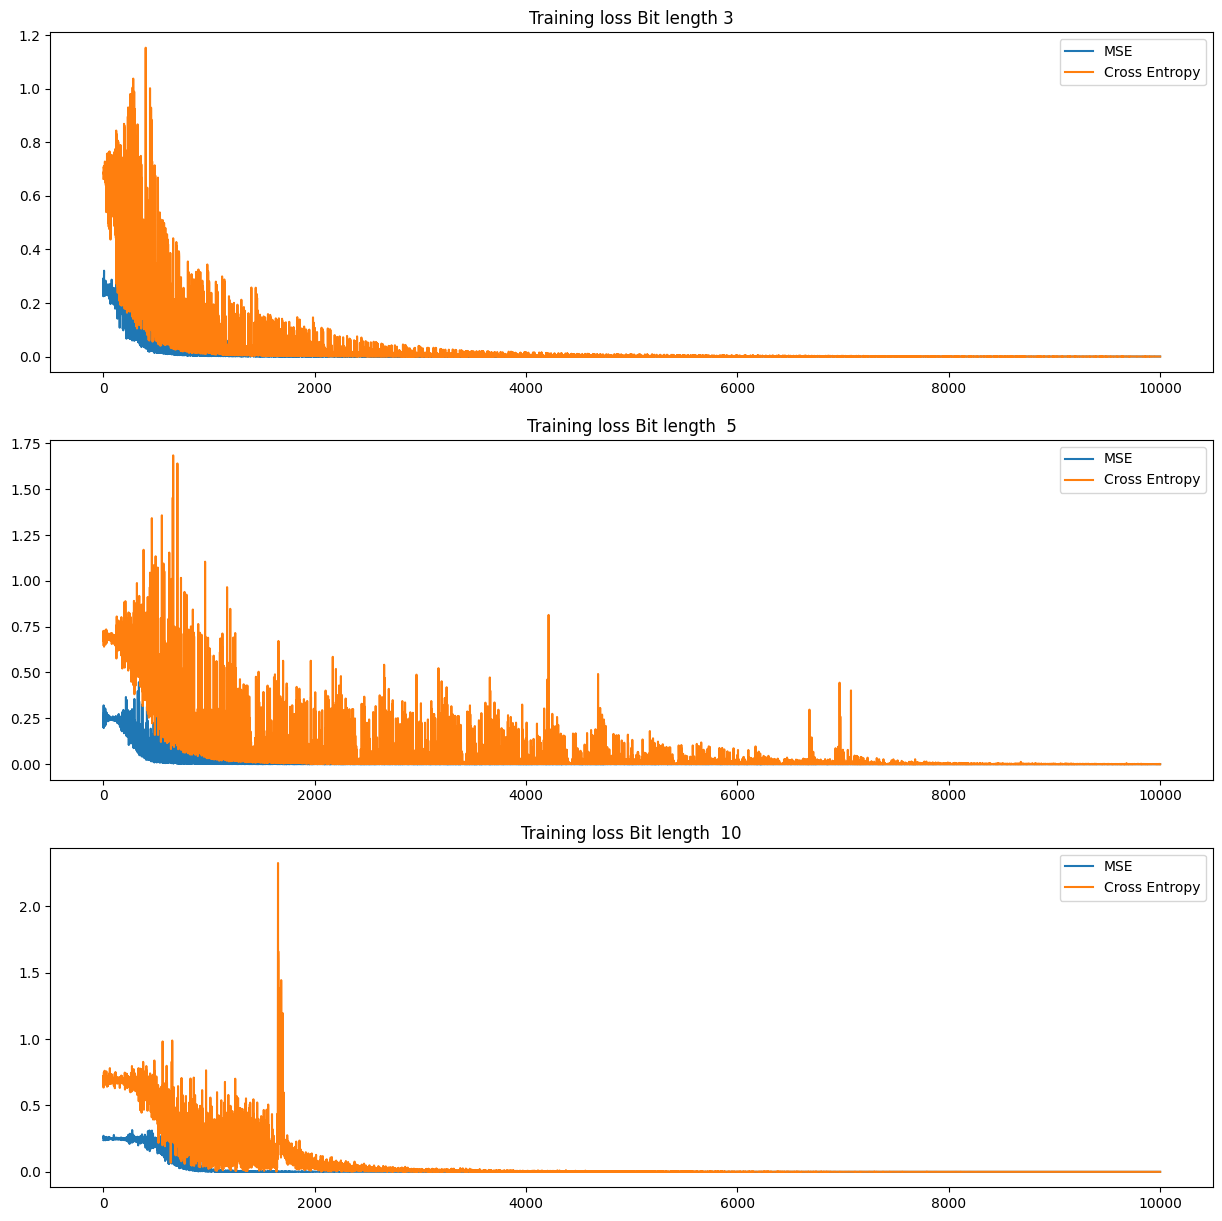

In [83]:
fig , (model_3,model_5,model_10) =  plt.subplots(3,1,figsize=(15, 15))

model_3.plot(metric_bin_3_hid_5["train_loss"],label = "MSE")
model_3.plot(metric_bin_3_ce_hid_5["train_loss"],label = "Cross Entropy")
model_3.title.set_text("Training loss Bit length 3")
model_3.legend()

model_5.plot(metric_bin_5_hid_5["train_loss"],label = "MSE")
model_5.plot(metric_bin_5_ce_hid_5["train_loss"],label = "Cross Entropy")
model_5.legend()
model_5.title.set_text("Training loss Bit length  5")

model_10.plot(metric_bin_10_hid_5["train_loss"],label = "MSE")
model_10.plot(metric_bin_10_ce_hid_5["train_loss"],label = "Cross Entropy")
model_10.legend()
model_10.title.set_text("Training loss Bit length  10")

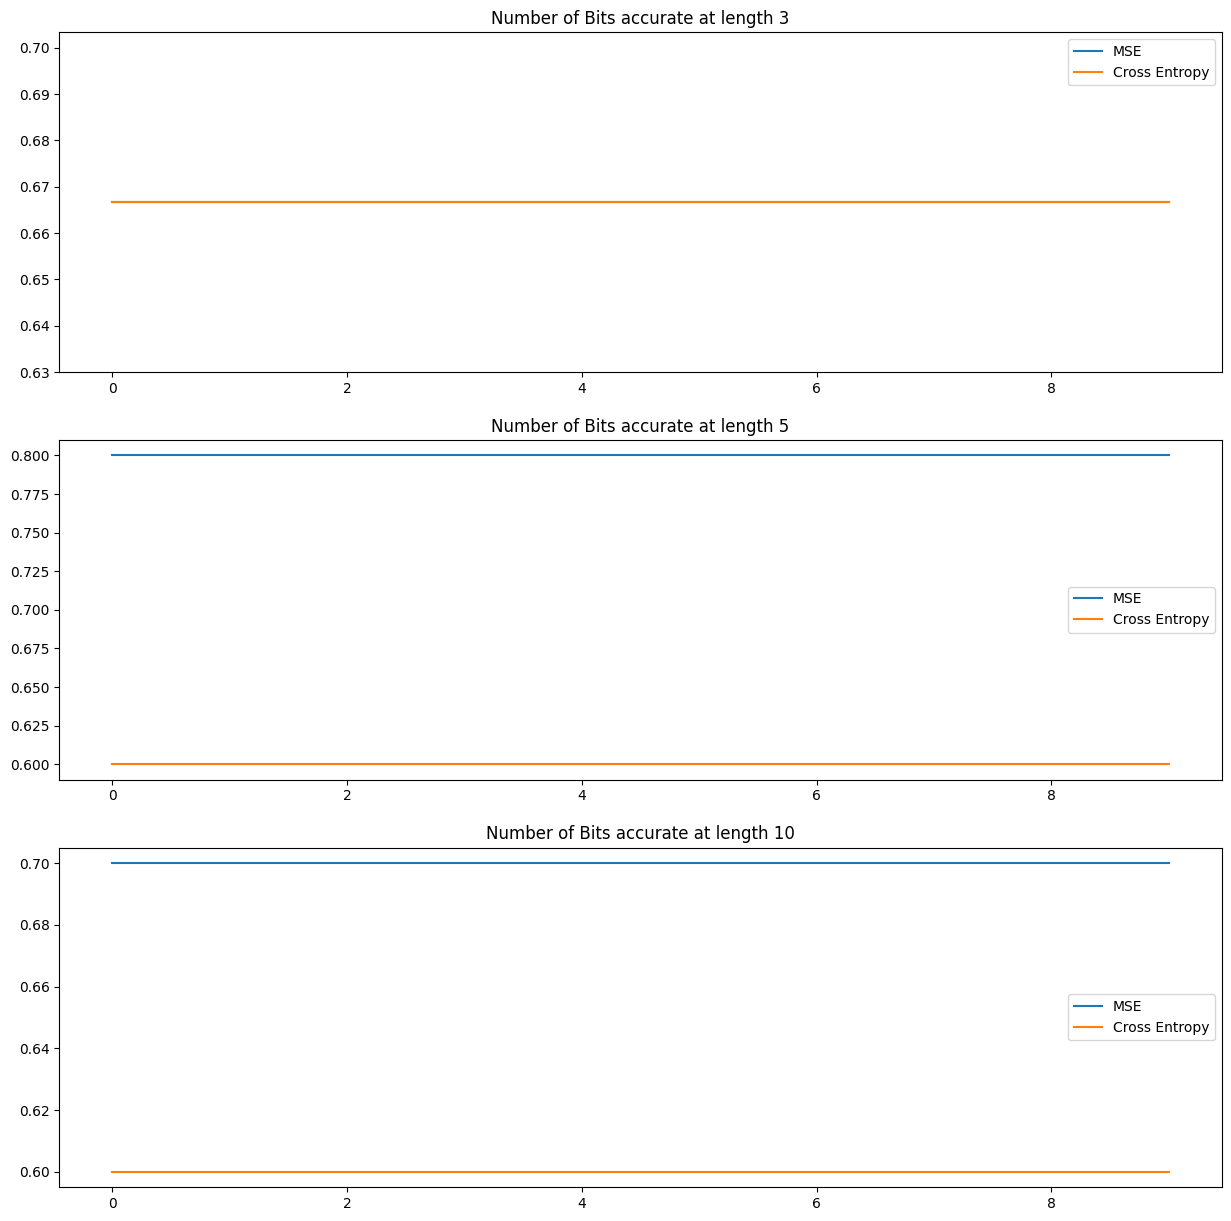

In [85]:
fig , (model_3,model_5,model_10) =  plt.subplots(3,1,figsize=(15, 15))
model_3.plot(metric_bin_3_hid_5["correct_test"],label = "MSE")
model_3.plot(metric_bin_3_ce_hid_5["correct_test"],label = "Cross Entropy")
model_3.title.set_text("Number of Bits accurate at length 3")
model_3.legend()


model_5.plot(metric_bin_5_hid_5["correct_test"],label = "MSE")
model_5.plot(metric_bin_5_ce_hid_5["correct_test"],label = "Cross Entropy")
model_5.title.set_text("Number of Bits accurate at length 5")
model_5.legend()

model_10.plot(metric_bin_10_hid_5["correct_test"],label = "MSE")
model_10.plot(metric_bin_10_ce_hid_5["correct_test"],label = "Cross Entropy")
model_10.title.set_text("Number of Bits accurate at length 10")
model_10.legend()

**MSE Hidden layer = 10**

In [86]:
model_bin_3_hid_10,metric_bin_3_hid_10 = train_bin_add(train_input = generate_data(size = train_size,l=3) , test_input = generate_data(size = test_size,l=3),loss_f=nn.MSELoss() ,hidstate = 10)
model_bin_5_hid_10,metric_bin_5_hid_10 = train_bin_add(train_input = generate_data(size = train_size,l=5) , test_input = generate_data(size = test_size,l=5) ,loss_f=nn.MSELoss(),hidstate = 10)
model_bin_10_hid_10,metric_bin_10_hid_10 = train_bin_add(train_input = generate_data(size = train_size,l=10) , test_input = generate_data(size = test_size,l=10),loss_f=nn.MSELoss() ,hidstate = 10)


Streaming output truncated to the last 5000 lines.























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [88]:
test_bin_add(model_bin_3_hid_10,test_data = generate_data(size = 20,l=3))

Bit accuracy : 100.0 %


In [89]:
test_bin_add(model_bin_5_hid_10,test_data = generate_data(size = 20,l=5))

Bit accuracy : 100.0 %


In [90]:
test_bin_add(model_bin_10_hid_10,test_data = generate_data(size = 20,l=10))

Bit accuracy : 100.0 %


**Cross entropy loss Hidden layer = 10**

In [92]:
model_bin_3_ce_hid_10,metric_bin_3_ce_hid_10 = train_bin_add(train_input = generate_data(size = train_size,l=3) , test_input = generate_data(size = test_size,l=3) ,loss_f=nn.BCELoss() ,hidstate = 10)
model_bin_5_ce_hid_10,metric_bin_5_ce_hid_10 = train_bin_add(train_input = generate_data(size = train_size,l=5) , test_input = generate_data(size = test_size,l=5)  ,loss_f=nn.BCELoss(),hidstate = 10)
model_bin_10_ce_hid_10,metric_bin_10_ce_hid_10 = train_bin_add(train_input = generate_data(size = train_size,l=10) , test_input = generate_data(size = test_size,l=10) ,loss_f=nn.BCELoss() ,hidstate = 10)


Streaming output truncated to the last 5000 lines.























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [93]:
test_bin_add(model_bin_3_ce_hid_10,test_data = generate_data(size = 20,l=3))

Bit accuracy : 100.0 %


In [94]:
test_bin_add(model_bin_5_ce_hid_10,test_data = generate_data(size = 20,l=5))


Bit accuracy : 100.0 %


In [104]:
test_bin_add(model_bin_10_ce_hid_10,test_data = generate_data(size = 20,l=10))


Bit accuracy : 100.0 %


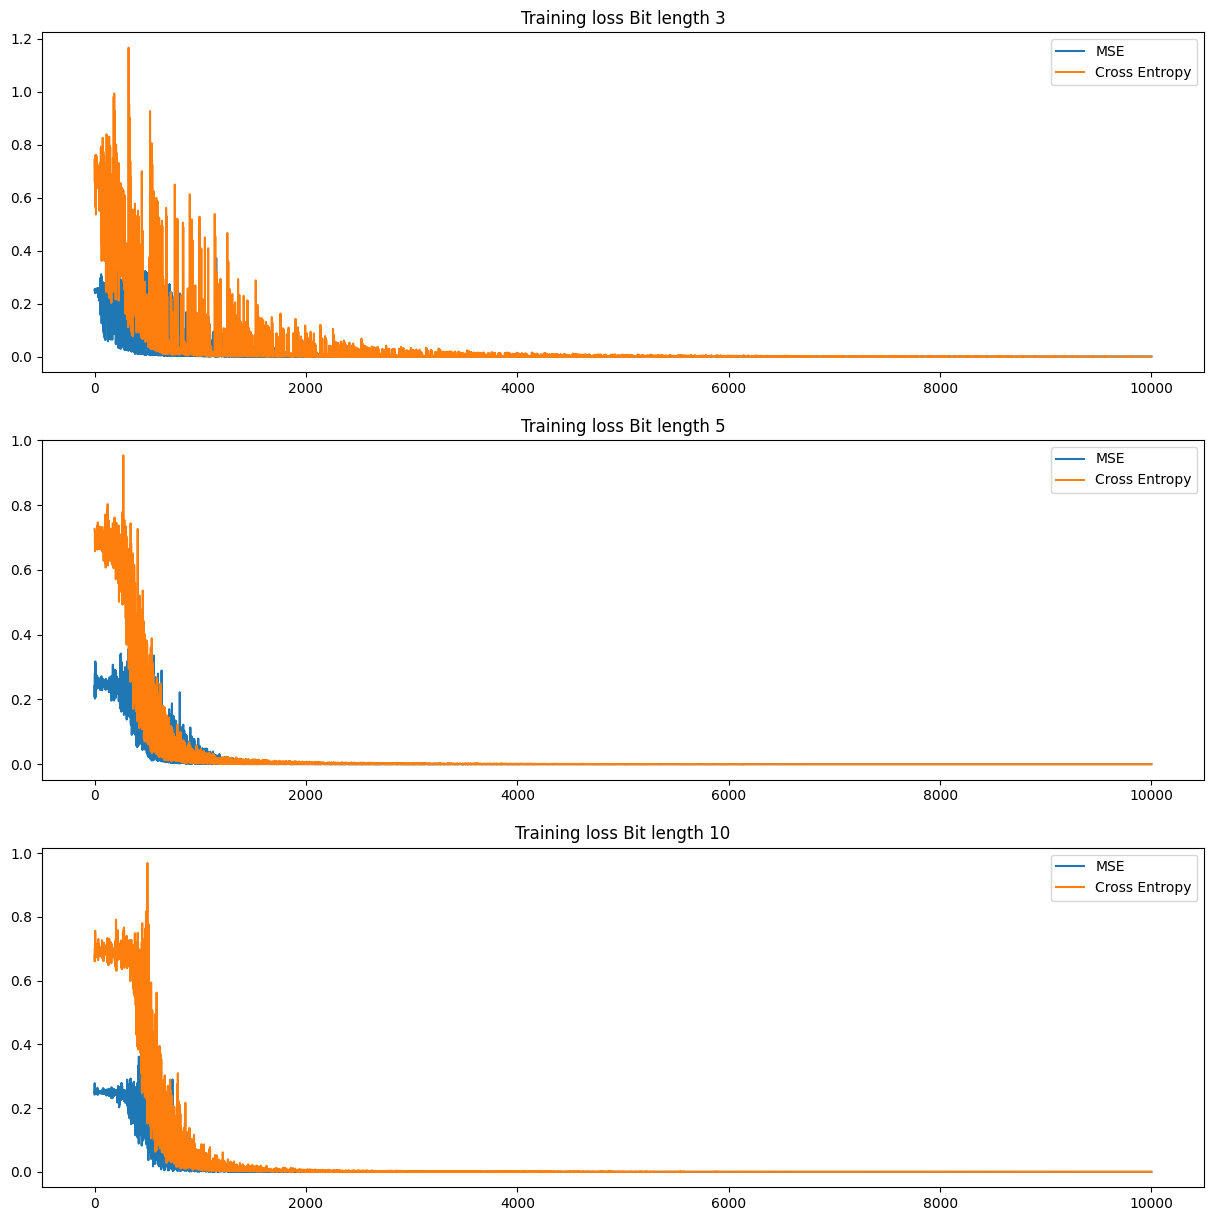

In [111]:
fig , (model_3,model_5,model_10) =  plt.subplots(3,1,figsize=(15, 15))
model_3.plot(metric_bin_3_hid_10["train_loss"],label = "MSE")
model_3.plot(metric_bin_3_ce_hid_10["train_loss"],label = "Cross Entropy")
model_3.title.set_text("Training loss Bit length 3")
model_3.legend()


model_5.plot(metric_bin_5_hid_10["train_loss"],label = "MSE")
model_5.plot(metric_bin_5_ce_hid_10["train_loss"],label = "Cross Entropy")
model_5.title.set_text("Training loss Bit length 5")
model_5.legend()

model_10.plot(metric_bin_10_hid_10["train_loss"],label = "MSE")
model_10.plot(metric_bin_10_ce_hid_10["train_loss"],label = "Cross Entropy")
model_10.title.set_text("Training loss Bit length 10")
model_10.legend()